# CUDA Memory Allocations

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Brain_Dump-red)
![Tag](https://img.shields.io/badge/Level-Beginner-green)


```{contents}
```

In [1]:
%pip install -q omniverse==0.0.63

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gc
import logging
import sys
from typing import Callable

import pandas as pd
import torch
from rich.pretty import pprint
from torch.profiler import ProfilerActivity, profile

from omnivault.utils.reproducibility.seed import seed_all

In [10]:
assert torch.cuda.is_available()
device = torch.device("cuda")
seed_all(42, True, False)

42

## Understanding GPU Memory 1: Visualizing All Allocations over Time

```{figure} ./assets/pytorch-understanding-gpu-memory-0.png
---
name: pytorch-understanding-gpu-memory-0
---

Interpreting the graph.

**Image Credit: [Understanding GPU Memory 1: Visualizing All Allocations over Time](https://pytorch.org/blog/understanding-gpu-memory-1/)**
```

We quote the following from the
[PyTorch blog](https://pytorch.org/blog/understanding-gpu-memory-1/):

The **Memory Snapshot** tool provides a fine-grained GPU memory visualization
for debugging GPU OOMs. Captured memory snapshots will show memory events
including allocations, frees and OOMs, along with their stack traces.

In a snapshot, each tensor’s memory allocation is color coded separately. The x
axis is over time, and the y axis is the amount of GPU memory in MB. The
snapshot is interactive, so we can observe the stack trace for any allocation by
mousing over. Try it yourself at
https://github.com/pytorch/pytorch.github.io/blob/site/assets/images/understanding-gpu-memory-1/snapshot.html.

In this snapshot, there are 3 peaks showing the memory allocations over 3
training iterations (this is configerable). When looking at the peaks, it is
**easy to see the rise of memory in the forward pass** and the **fall during the
backward pass** as the gradients are computed. It is also possible to see that
the program has the **same pattern of memory use iteration to iteration**. One
thing that stands out is the many **tiny spikes in memory**, by mousing over
them, we see that they are buffers used temporarily by convolution operators.

In [6]:
# (c) Meta Platforms, Inc. and affiliates.

import logging
import socket
from datetime import datetime

import torch
from torchvision import models
from tqdm.auto import tqdm

logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000


def start_record_memory_history() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not recording memory history")
        return

    logger.info("Starting snapshot record_memory_history")
    torch.cuda.memory._record_memory_history(max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT)


def stop_record_memory_history() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not recording memory history")
        return

    logger.info("Stopping snapshot record_memory_history")
    torch.cuda.memory._record_memory_history(enabled=None)


def export_memory_snapshot() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not exporting memory snapshot")
        return

    # Prefix for file names.
    host_name = socket.gethostname()
    timestamp = datetime.now().strftime(TIME_FORMAT_STR)
    file_prefix = f"{host_name}_{timestamp}"

    try:
        logger.info(f"Saving snapshot to local file: {file_prefix}.pickle")
        torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
    except Exception as e:
        logger.error(f"Failed to capture memory snapshot {e}")
        return


# Simple Resnet50 example to demonstrate how to capture memory visuals.
def run_resnet50(num_iters: int = 5, device: str = "cuda:0", force_memory_leak: bool = True) -> None:
    model = models.resnet50().to(device=device)
    inputs = torch.randn(1, 3, 224, 224, device=device)
    labels = torch.rand_like(model(inputs))
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Start recording memory snapshot history
    start_record_memory_history()

    for _ in tqdm(range(num_iters)):
        pred = model(inputs)
        loss_fn(pred, labels).backward()
        optimizer.step()
        if not force_memory_leak:
            optimizer.zero_grad(set_to_none=True)

    # Create the memory snapshot file
    export_memory_snapshot()

    # Stop recording memory snapshot history
    stop_record_memory_history()

    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [7]:
run_resnet50(num_iters=5, device="cuda:0", force_memory_leak=True)

  0%|          | 0/5 [00:00<?, ?it/s]

As stated in the pytorch blog post, we "forgot" to clear the gradients after
each iteration as `optimizer.zero_grad(set_to_none=True)` was not invoked. This
means that the gradients are accumulated across iterations and this is why the
memory increased sharply after the first iteration. This is a classic example of
a memory leak in deep learning workflows, though I suspect not many would make
this mistake in practice and real memory leaks are more subtle and harder to
detect! To be more concrete, we have the following:

1. First iteration: Model parameters have no gradients initially, after the
   backward pass of the first iteration, the gradients are calculated and stored
   in the `.grad` attribute of the model parameters. These gradients require
   memory to store.
2. Second iteration: The gradients from the first iteration are still stored in
   memory, and since they are not cleared after the first iteration, the memory
   spike is observed.
3. Subsequent iterations: The memory usage stabilizes because the gradients are
   not newly allocated but are reused and modified in each iteration.

```{figure} ./assets/pytorch-understanding-gpu-memory-1.png
---
name: pytorch-understanding-gpu-memory-1
---

Memory increase after first iteration.

**Image Credit: [Understanding GPU Memory 1: Visualizing All Allocations over Time](https://pytorch.org/blog/understanding-gpu-memory-1/)**
```

```{figure} ./assets/pytorch-understanding-gpu-memory-2.png
---
name: pytorch-understanding-gpu-memory-2
---

Lingering gradient tensors.

**Image Credit: [Understanding GPU Memory 1: Visualizing All Allocations over Time](https://pytorch.org/blog/understanding-gpu-memory-1/)**
```

Once we add `optimizer.zero_grad(set_to_none=True)` after the backward pass, the
spike in the 2nd iteration is much lesser in comparison. However, as highlighted
by the authors there is still a spike.

In [8]:
run_resnet50(num_iters=5, device="cuda:0", force_memory_leak=False)

  0%|          | 0/5 [00:00<?, ?it/s]


```{figure} ./assets/pytorch-understanding-gpu-memory-3.png
---
name: pytorch-understanding-gpu-memory-3
---

Fixing the memory leak.

**Image Credit: [Understanding GPU Memory 1: Visualizing All Allocations over Time](https://pytorch.org/blog/understanding-gpu-memory-1/)**
```

Now the further increase after the first forward and backward pass is due to the
optimizer's internal state. The optimizer we chose stores the momentum and other
state information for each parameter. These states like the first and second
moments of the gradients will be initialized during the first call to
`optimizer.step()` and will be stored in memory. This is why we see a spike in
memory usage after the first call to `optimizer.step()`. But this spike is much
lesser than if we had not cleared the gradients after the backward pass.

/opt/conda/lib/python3.10/site-packages/torch/profiler/profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")
STAGE:2024-08-12 07:05:25 34:34 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


  0%|          | 0/5 [00:00<?, ?it/s]

STAGE:2024-08-12 07:05:25 34:34 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-08-12 07:05:25 34:34 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-08-12 07:05:42 34:34 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


  0%|          | 0/5 [00:00<?, ?it/s]

STAGE:2024-08-12 07:05:42 34:34 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-08-12 07:05:42 34:34 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


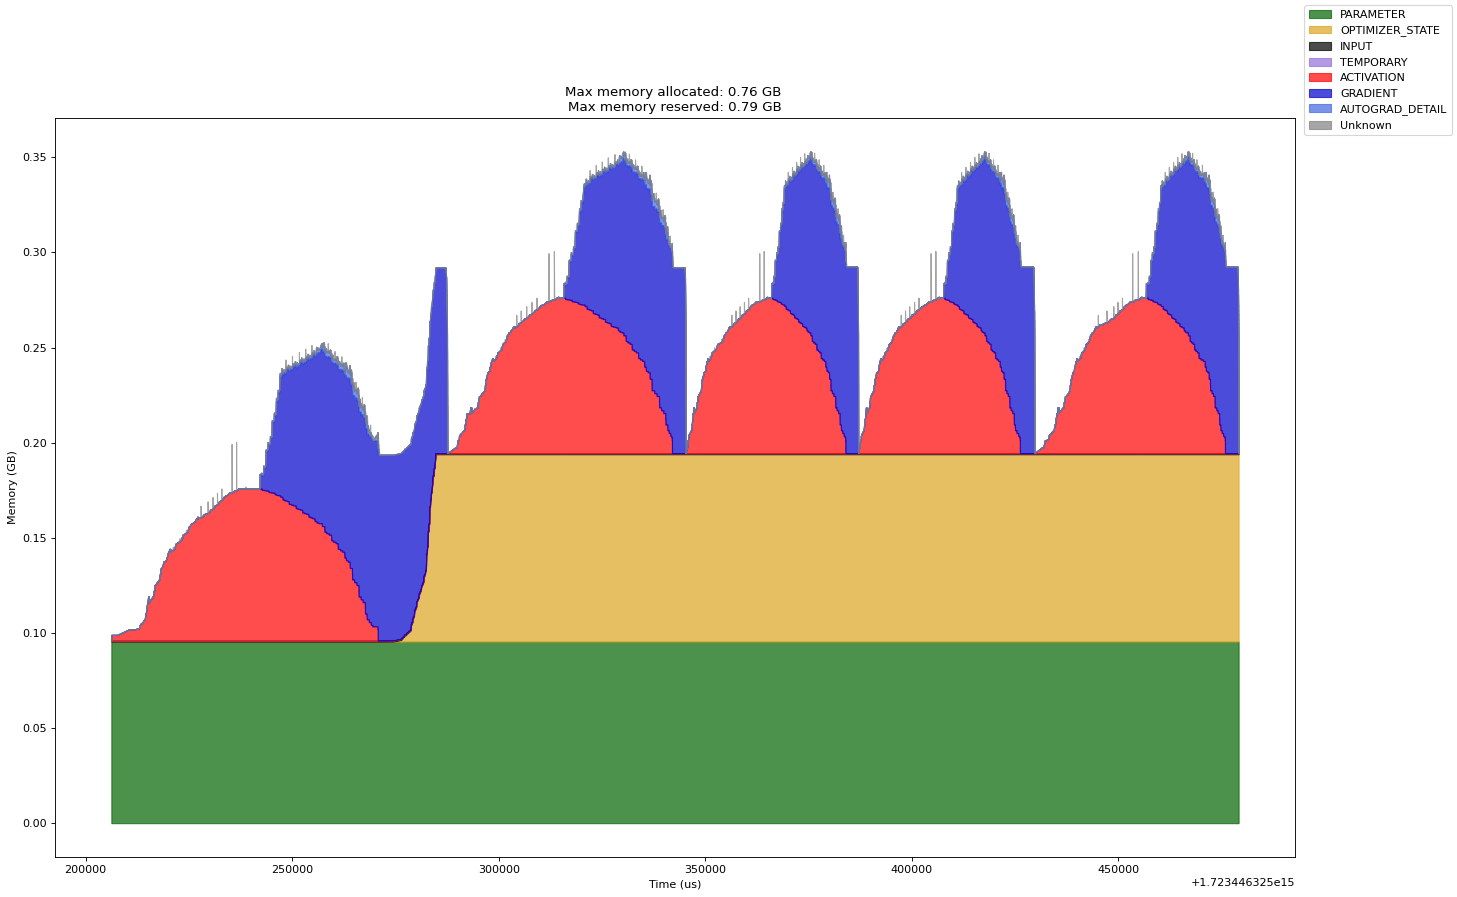

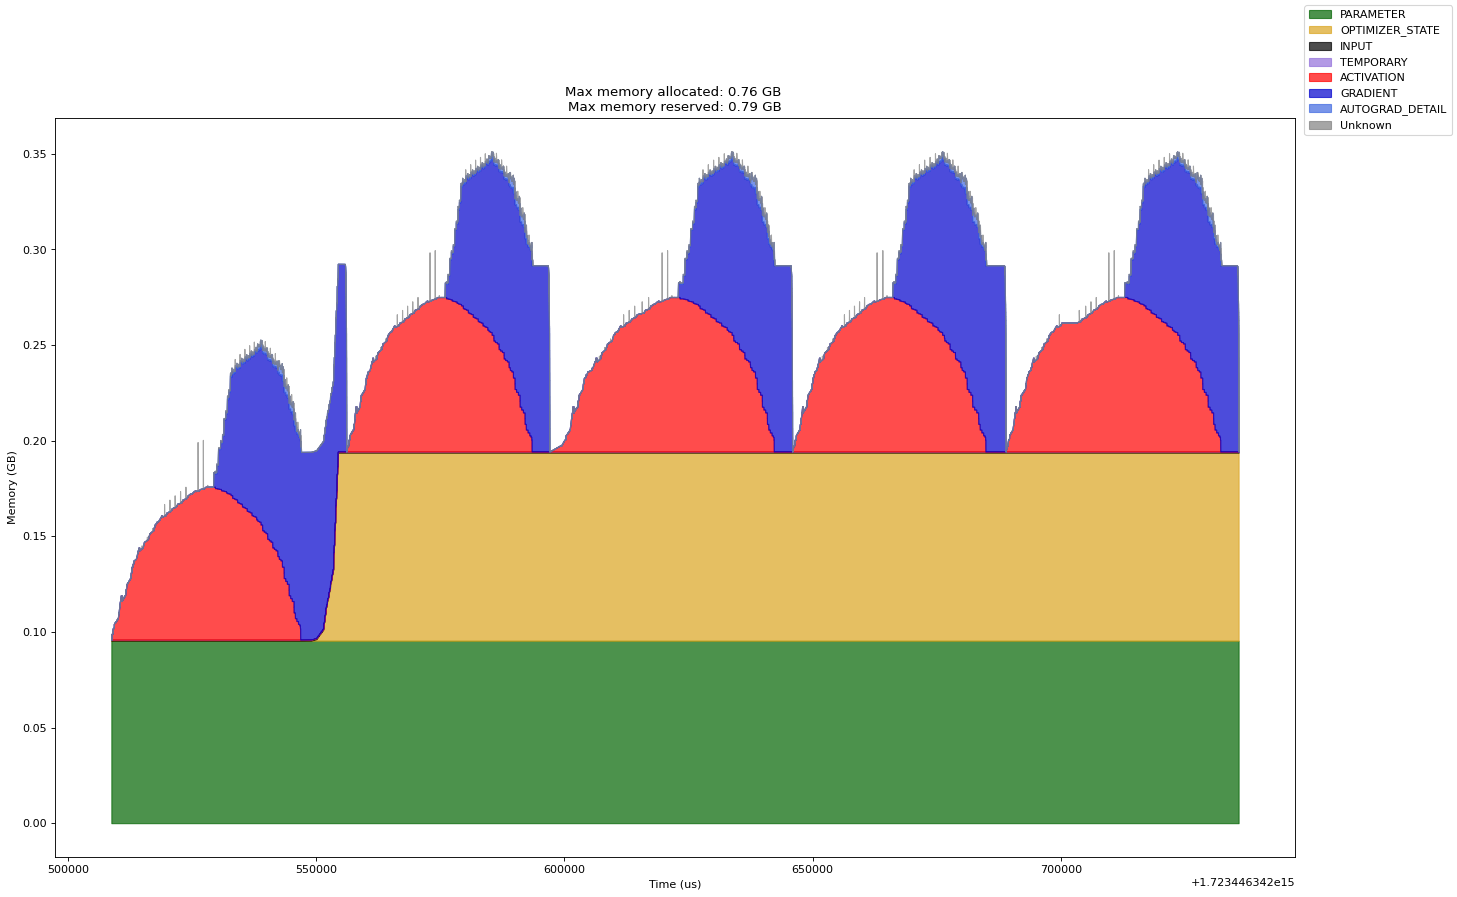

In [9]:
# (c) Meta Platforms, Inc. and affiliates.
import logging
import socket
from datetime import datetime

import torch

from torch.autograd.profiler import record_function
from torchvision import models
from tqdm.auto import tqdm

logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"


def trace_handler(prof: torch.profiler.profile) -> None:
    # Prefix for file names.
    host_name = socket.gethostname()
    timestamp = datetime.now().strftime(TIME_FORMAT_STR)
    file_prefix = f"{host_name}_{timestamp}"

    # Construct the trace file.
    prof.export_chrome_trace(f"{file_prefix}.json.gz")

    # Construct the memory timeline file.
    prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")


def run_resnet50(num_iters: int = 5, device: str = "cuda:0") -> None:
    model = models.resnet50().to(device=device)
    inputs = torch.randn(1, 3, 224, 224, device=device)
    labels = torch.rand_like(model(inputs))
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        on_trace_ready=trace_handler,
    ) as prof:
        for _ in tqdm(range(num_iters)):
            prof.step()
            with record_function("## forward ##"):
                pred = model(inputs)

            with record_function("## backward ##"):
                loss_fn(pred, labels).backward()

            with record_function("## optimizer ##"):
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)


if __name__ == "__main__":
    # Warm up
    run_resnet50()
    # Run the resnet50 model
    run_resnet50()

## Finding and Removing Reference Cycles

For more advanced debugging memory leaks with reference cycles, please have a good read at [Understanding GPU Memory 2: Finding and Removing Reference Cycles](https://pytorch.org/blog/understanding-gpu-memory-2/)
written the PyTorch team. I quote their code snippet below.

In [12]:
# (c) Meta Platforms, Inc. and affiliates.
from __future__ import annotations

import argparse
import asyncio
import gc
import logging
import socket
from datetime import datetime

import torch

logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000


def start_record_memory_history() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not recording memory history")
        return

    logger.info("Starting snapshot record_memory_history")
    torch.cuda.memory._record_memory_history(max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT)


def stop_record_memory_history() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not recording memory history")
        return

    logger.info("Stopping snapshot record_memory_history")
    torch.cuda.memory._record_memory_history(enabled=None)


def export_memory_snapshot() -> None:
    if not torch.cuda.is_available():
        logger.info("CUDA unavailable. Not exporting memory snapshot")
        return

    # Prefix for file names.
    host_name = socket.gethostname()
    timestamp = datetime.now().strftime(TIME_FORMAT_STR)
    file_prefix = f"{host_name}_{timestamp}"

    try:
        logger.info(f"Saving snapshot to local file: {file_prefix}.pickle")
        torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
    except Exception as e:
        logger.error(f"Failed to capture memory snapshot {e}")
        return


# This function will leak tensors due to the reference cycles.
def simple_leak(
    tensor_size: int,
    gc_interval: int | None = None,
    num_iter: int = 30000,
    device: str = "cuda:0",
) -> None:
    class Node:
        def __init__(self, T: torch.Tensor) -> None:
            self.tensor = T
            self.link = None

    for i in range(num_iter):
        A = torch.zeros(tensor_size, device=device)
        B = torch.zeros(tensor_size, device=device)
        a, b = Node(A), Node(B)
        # A reference cycle will force refcounts to be non-zero, when
        # a and b go out of scope.
        a.link, b.link = b, a
        # Python will eventually gc a and b, but may OOM on the CUDA
        # device before that happens (since python runtime doesn't
        # know about CUDA memory usage).

        # Since implicit gc is not called frequently enough due to
        # generational gc, adding an explicit gc is necessary as Python
        # runtime does not know about CUDA memory pressure.
        # https://en.wikipedia.org/wiki/Tracing_garbage_collection#Generational_GC_(ephemeral_GC)
        if gc_interval and i % int(gc_interval) == 0:
            gc.collect()


async def awaitable_leak(
    tensor_size: int,
    gc_interval: int | None = None,
    num_iter: int = 100000,
    device: str = "cuda:0",
) -> None:
    class AwaitableTensor:
        def __init__(self, tensor_size: int, device: str) -> None:
            self._tensor_size = tensor_size
            self._device = device
            self._tensor = None

        def wait(self) -> torch.Tensor:
            self._tensor = torch.zeros(self._tensor_size, device=self._device)
            return self._tensor

    class AwaitableTensorWithViewCallBack:
        def __init__(
            self,
            tensor_awaitable: AwaitableTensor,
            view_dim: int,
        ) -> None:
            self._tensor_awaitable = tensor_awaitable
            self._view_dim = view_dim
            # Add a view filter callback to the tensor.
            self._callback = lambda ret: ret.view(-1, self._view_dim)

        def wait(self) -> torch.Tensor:
            return self._callback(self._tensor_awaitable.wait())

    for i in range(num_iter):
        # Create an awaitable tensor
        a_tensor = AwaitableTensor(tensor_size, device)

        # Apply a view filter callback on the awaitable tensor.
        AwaitableTensorWithViewCallBack(a_tensor, 4).wait()

        # a_tensor will go out of scope.

        if gc_interval and i % int(gc_interval) == 0:
            gc.collect()


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="A memory_leak binary instance")
    parser.add_argument(
        "--gc_collect_interval",
        default=None,
        help="Explicitly call GC every given interval. Default is off.",
    )
    parser.add_argument(
        "--workload",
        default="simple",
        help="Toggle which memory leak workload to run. Options are simple, awaitable.",
    )
    parser.add_argument(
        "--warn_tensor_cycles",
        action="store_true",
        default=False,
        help="Toggle whether to enable reference cycle detector.",
    )
    args = parser.parse_args()

    if args.warn_tensor_cycles:
        from tempfile import NamedTemporaryFile

        from torch.utils.viz._cycles import observe_tensor_cycles

        logger.info("Enabling warning for Python reference cycles for CUDA Tensors.")

        def write_and_log(html):
            with NamedTemporaryFile("w", suffix=".html", delete=False) as f:
                f.write(html)
                logger.warning(
                    "Reference cycle includes a CUDA Tensor see visualization of cycle %s",
                    f.name,
                )

        observe_tensor_cycles(write_and_log)
    else:
        # Start recording memory snapshot history
        start_record_memory_history()

    # Run the workload with a larger tensor size.
    # For smaller sizes, we will not CUDA OOM as gc will kick in often enough
    # to reclaim reference cycles before an OOM occurs.
    size = 2**26  # 256 MB
    try:
        if args.workload == "awaitable":
            size *= 2
            logger.info(f"Running tensor_size: {size*4/1024/1024} MB")
            asyncio.run(awaitable_leak(tensor_size=size, gc_interval=args.gc_collect_interval))
        elif args.workload == "simple":
            logger.info(f"Running tensor_size: {size*4/1024/1024} MB")
            simple_leak(tensor_size=size, gc_interval=args.gc_collect_interval)
        else:
            raise Exception("Unknown workload.")
    except Exception:
        logger.exception(f"Failed to allocate {size*4/1024/1024} MB")

    # Create the memory snapshot file
    export_memory_snapshot()

    # Stop recording memory snapshot history
    stop_record_memory_history()


## References and Further Readings

-   [Understanding GPU Memory - Part 1](https://pytorch.org/blog/understanding-gpu-memory-1/)
-   [Understanding GPU Memory - Part 2](https://pytorch.org/blog/understanding-gpu-memory-2/)